# Example of training the model for different dataset

- 
- This is using some fastai (https://github.com/fastai/fastai) stuff


## Setup

In [1]:
%matplotlib inline
%load_ext autoreload
# use %autoreload command to reload all libraries

In [2]:
from IPython.core.debugger import set_trace
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
#InteractiveShell.ast_node_interactivity = "last_expr"

In [3]:
# Python path fixing so we can import libraries
import sys
import os
sys_paths = ['../', # Adding yolov3_pytorch to python paths
            '../../hands/fastai', # Fastai lib to help data handling etc: https://github.com/fastai/fastai
            '../../../data/coco/cocoapi/PythonAPI',
            ]
for p in sys_paths:
    p = os.path.abspath(p)
    if p not in sys.path:
        sys.path.append(p)

In [4]:
import time
import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import datasets, transforms
from matplotlib import patches, patheffects

In [5]:
print("Pytorch: {}".format(torch.__version__))

Pytorch: 0.4.0


In [6]:
from yolov3_pytorch.utils import *
from yolov3_pytorch.yolov3 import *
from yolov3_pytorch.yolov3_tiny import *

In [7]:
from voc_utils import *
from yolov3_pytorch.fastai_utils import *

In [8]:
%autoreload

# Dataset

In [9]:
data_filenames = ["../../../data/voc/2007_train.txt", "../../../data/voc/2007_val.txt"]
#md = get_voc_md(data_filenames=data_filenames, sz=416, data_max_lines=[10*32, 5*32])
md = get_voc_md(data_filenames=data_filenames, sz=416)

In [10]:
batch_x, batch_y = next(iter(md.trn_dl))

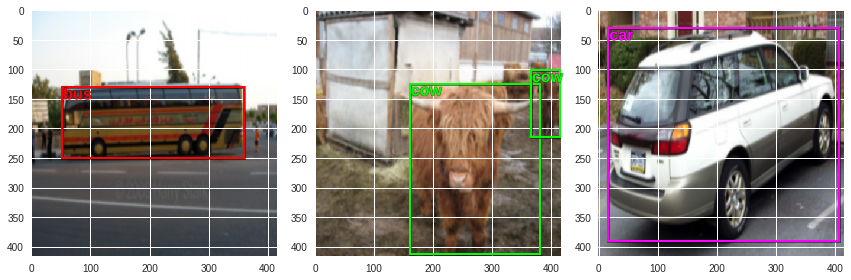

In [11]:
plot_img_data(batch_x, batch_y, rows=1, class_names=VocDataset.CLASS_NAMES)

# Model

In [12]:
%autoreload

In [13]:
# model = Yolov3Tiny(num_classes=len(VocDataset.CLASS_NAMES))
# model.load_backbone('../data/models/yolov3_tiny_coco_01.h5')

In [14]:
model = Yolov3(num_classes=len(VocDataset.CLASS_NAMES))
model.load_backbone('../data/models/yolov3_coco_01.h5')[0]

In [23]:
model.freeze_backbone()
model.freeze_info()
_ = model.cuda()

Layer: param.requires_grad
backbone :  {False}
yolo_0_pre :  {True}
yolo_1_c :  {True}
yolo_1_prep :  {True}
yolo_2_c :  {True}
yolo_2_prep :  {True}


# Training

In [16]:
sz = 416

yolo_loss = YoloLoss(model)
yolo_loss_metrics = YoloLossMetrics(yolo_loss)
learn = YoloLearner(md, model,
                    models_name=os.path.abspath("data/models"),
                    clip=1000,
                    crit=yolo_loss,
                    metrics=(yolo_loss_metrics.layer_losses() + yolo_loss_metrics.individual_losses()))

In [17]:
%%time
_ = learn.fit(0.0001, n_cycle=2, cycle_len=1)

Widget Javascript not detected.  It may not be installed or enabled properly.


epoch      trn_loss   val_loss   yolo_l_0   yolo_l_1   yolo_l_2   loss_coord loss_conf  loss_cls   
    0      2723.100428 497.55488  127.482193 153.609805 214.587624 50.865432  237.078928 207.735261
    1      783.59351  348.3016   110.211663 109.290459 128.223874 42.079209  232.689867 72.95692  

CPU times: user 11min 43s, sys: 2min 46s, total: 14min 29s
Wall time: 3min 27s


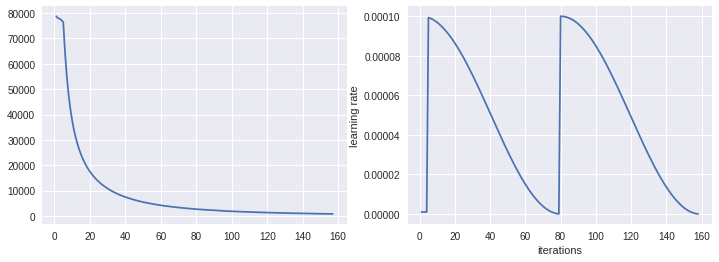

In [18]:
learn_sched_plot(learn)

In [21]:
%%time
_ = learn.fit(0.0001, n_cycle=1, cycle_len=4)

epoch      trn_loss   val_loss   yolo_l_0   yolo_l_1   yolo_l_2   loss_coord loss_conf  loss_cls   
    0      351.353727 364.137399 97.695805  116.461985 150.295149 68.279297  209.757969 86.415672 
    1      291.022423 295.226454 84.436704  92.147436  116.968074 40.433537  197.606722 55.511956 
    2      240.385925 273.798483 76.468661  83.998368  111.385719 29.323659  191.080041 51.449048 
    3      218.741981 269.889721 75.553536  82.570328  110.063314 27.922283  189.869286 50.395609 
    4      227.979935 295.300181 77.469243  90.295646  125.997561 42.0569    187.194612 64.510937 
    5      211.697289 271.996383 73.383703  83.040679  111.65426  31.756417  182.881258 53.440965 
 11%|█▏        | 9/79 [00:07<00:57,  1.22it/s, loss=211]

KeyboardInterrupt: 

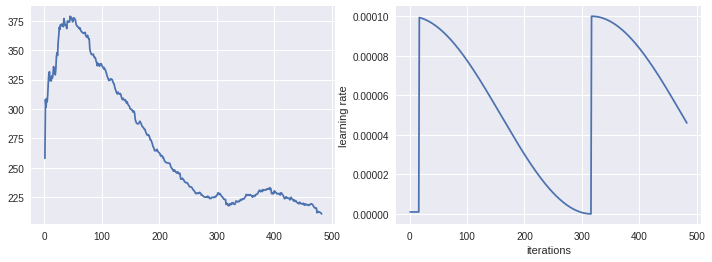

In [22]:
learn_sched_plot(learn)

In [ ]:
%%time
_ = learn.fit(0.00001, n_cycle=2, cycle_len=4)

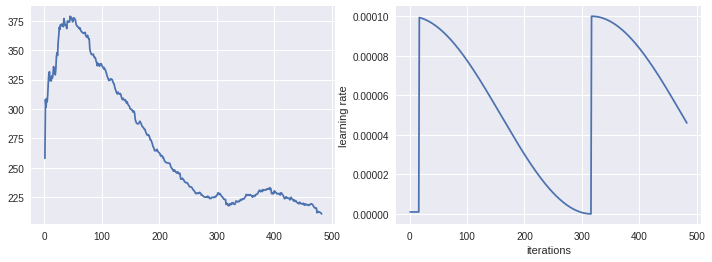

In [22]:
learn_sched_plot(learn)

# Manual Test

In [25]:
batch_x, batch_y = next(iter(md.val_dl))

In [37]:
preds = model.predict_img(batch_x)

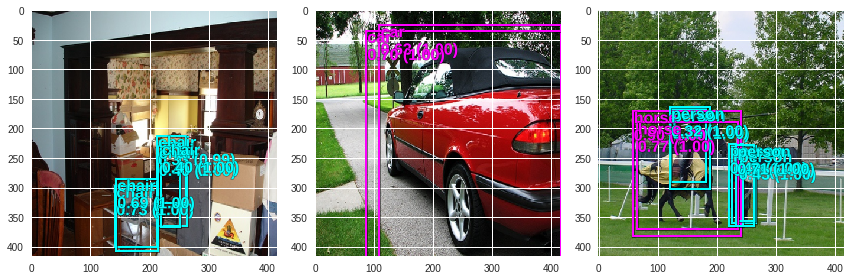

In [39]:
plot_multi_detections(batch_x[:3], preds, class_names=VocDataset.CLASS_NAMES)

In [41]:
preds_nms = [nms(p, nms_thresh=.4) for p in preds]

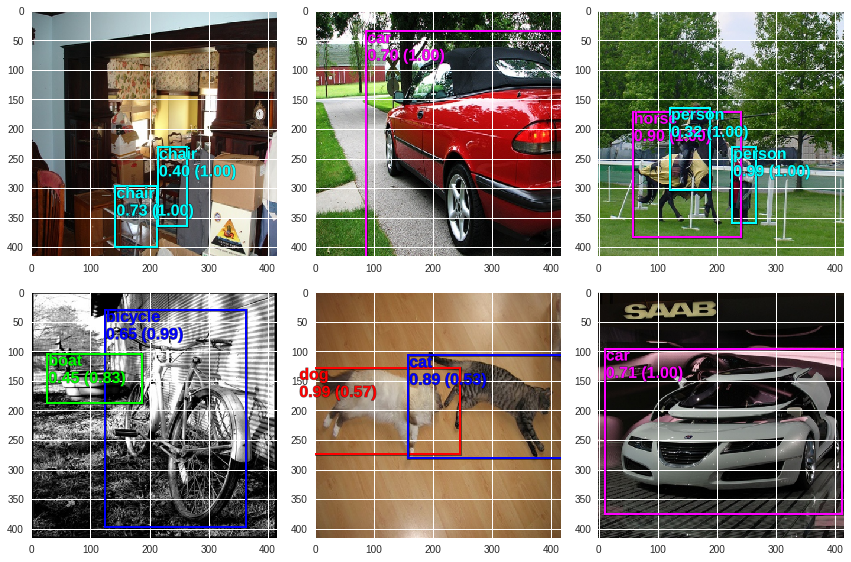

In [42]:
plot_multi_detections(batch_x[:6], preds_nms, class_names=VocDataset.CLASS_NAMES)

# Evaluate